---
---
---

# Brain Tumor Segmentation with U-Net 🧩

**Objective**:
Develop and evaluate a resource-efficient U-Net for delineating brain tumor subregions from multi-modal MRI.

---
---
---

---

## 1. Setup 📦

---

In [ ]:
# Data Management
import glob
import numpy as np
import pandas as pd

# Data Visualization
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

# Computational Modules
import math
from scipy.stats import norm, zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

# Deep Learning Frameworks
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

# Utils
from collections import defaultdict
import h5py
from google.colab import drive
from IPython.display import display, HTML, IFrame, Image
import os
from pathlib import Path
import random
import re
from tqdm import tqdm

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})


---

## 2. Data Access 📂

---

In [ ]:
# Define project root
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define file paths relative to drive structure
data_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data'
meta_data_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/meta_data.csv'
name_mapping_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/name_mapping.csv'
survival_info_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/survival_info.csv'
slice_paths = sorted(glob.glob(os.path.join(data_path, '*.h5')))  # get all .h5 files

In [ ]:
# Load CSVs into local dataframes
meta_data_df = pd.read_csv(meta_data_path)
name_mapping_df = pd.read_csv(name_mapping_path)
survival_info_df = pd.read_csv(survival_info_path)

In [ ]:
### TO BE EXECUTED BEFORE TRAINING FOR FULL DATASET ###
### Copy dataset locally and use instead for faster access ###

# !cp -r /content/drive/MyDrive/BraTS_Data /content/
# data_path = '/content/BraTS_Data/BraTS2020_training_data/content/data'
# slice_paths = sorted(glob.glob(os.path.join(data_path, '*.h5')))

---

## 3. Model Prerequisites ⚙️

---

#### **3a. Split imaging data into training and validation sets.**

For this v1 (baseline model), only a limited set of MRI volumes will be used due to runtime trouble on free-tier Colab. Once an entire workflow is established, a more fleshed-out splitting will take place for future versions.

In [ ]:
# Extract random patient/volume IDs for baseline model
random.seed(42)
selected_patients = random.sample(range(0, 368), 10)
print('Randomly selected patient IDs: ', selected_patients)

Randomly selected patient IDs:  [327, 57, 12, 140, 125, 114, 71, 52, 346, 279]


In [ ]:
# Convert numeric IDs into corresponding filename prefixes
selected_prefixes = [f'volume_{pid}_' for pid in selected_patients]
selected_prefixes

['volume_327_',
 'volume_57_',
 'volume_12_',
 'volume_140_',
 'volume_125_',
 'volume_114_',
 'volume_71_',
 'volume_52_',
 'volume_346_',
 'volume_279_']

In [ ]:
# Collect all slices belonging to selected patients
selected_slice_paths = [
    path for path in slice_paths
    if any(prefix in os.path.basename(path) for prefix in selected_prefixes)
]
print('Total selected slices: ', len(selected_slice_paths))
# selected_slice_paths

Total selected slices:  1550


In [ ]:
# Copy selected slices to local runtime (for faster I/O during training)
local_data_path = '/content/baseline_data'
os.makedirs(local_data_path, exist_ok=True)
for path in selected_slice_paths:
    filename = os.path.basename(path)
    !cp '{path}' '{local_data_path}/{filename}'

In [ ]:
# Rebuild slice list from local directory
local_slice_paths = sorted(glob.glob(os.path.join(local_data_path, '*.h5')))
print('Local slice count: ', len(local_slice_paths))

Local slice count:  1550


In [ ]:
# Group slices by patient (patient-level split)
patient_to_slices = defaultdict(list)
for path in local_slice_paths:
    filename = os.path.basename(path)
    patient_id = filename.split('_slice')[0]
    patient_to_slices[patient_id].append(path)
print(f'Patients found locally: {list(patient_to_slices.keys())}')

Patients found locally: ['volume_114', 'volume_125', 'volume_12', 'volume_140', 'volume_279', 'volume_327', 'volume_346', 'volume_52', 'volume_57', 'volume_71']


In [ ]:
# Seperate train and validation patients
patient_ids = list(patient_to_slices.keys())

train_patients = patient_ids[:8]
val_patients = patient_ids[8:]

print('Train patients:', train_patients)
print('Val patients:', val_patients)

Train patients: ['volume_114', 'volume_125', 'volume_12', 'volume_140', 'volume_279', 'volume_327', 'volume_346', 'volume_52']
Val patients: ['volume_57', 'volume_71']


In [ ]:
# Separate train and validation slice paths
train_paths = []
val_paths = []

for pid in train_patients:
    train_paths.extend(patient_to_slices[pid])
for pid in val_patients:
    val_paths.extend(patient_to_slices[pid])

print('Train slices:', len(train_paths))
print('Val slices:', len(val_paths))

Train slices: 1240
Val slices: 310


**Patient-Level Subset Selection and Split**

To keep training within runtime limits, a small baseline subset was created by randomly selecting four patients (seed = 42). All slices belonging to these patients were identified and copied locally to the Colab runtime to ensure faster disk access during training.

A deterministic 3:1 patient-level split was then applied. The split is performed at the patient level (not slice level) to prevent data leakage, ensuring that no slices from the same volume appear in both sets.

This setup keeps the experiment lightweight while preserving proper evaluation structure.

#### **3b. Format and standardize slices via PyTorch Dataset.**

In [ ]:
class BraTSDataset(Dataset):
    """
    PyTorch Dataset for loading 2D BraTS slices stored as .h5 files,
    with optional minimal augmentations for v2.

    Each file contains:
        - image: (H, W, 4)
              MRI modalities in order: [T1, T1Gd, T2, T2-FLAIR]
        - mask:  (H, W, 3)
              Binary tumor subregions: [NEC/NET, ED, ET]

    Output format:
        - image tensor: (4, H, W), float32
        - mask tensor:  (3, H, W), float32
    """

    def __init__(self, slice_paths, augment=False):
        """
        Args:
            slice_paths (list): List of file paths to .h5 slice files.
            augment (bool): Whether to apply on-the-fly augmentations.
        """
        self.slice_paths = slice_paths
        self.augment = augment

        # Minimal v2 augmentations
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),  # ±15 degree rotations
        ])

    def __len__(self):
        """Returns total number of slices."""
        return len(self.slice_paths)

    def __getitem__(self, idx):
        """
        Loads and processes a single slice from disk with optional augmentation.

        Steps:
            1. Load image + mask from disk (lazy loading)
            2. Convert to float32
            3. Apply per-slice, per-modality z-score normalization
            4. Apply augmentation if enabled
            5. Convert to channel-first format (C, H, W)
            6. Convert to torch.Tensor
        """
        file_path = self.slice_paths[idx]

        # Load slice from disk (lazy loading)
        with h5py.File(file_path, 'r') as file:
            image = file['image'][:]   # (H, W, 4)
            mask  = file['mask'][:]    # (H, W, 3)

        # Convert to float32
        image = image.astype(np.float32)
        mask  = mask.astype(np.float32)

        # Per-modality z-score normalization
        for c in range(image.shape[-1]):
            channel = image[:, :, c]
            mean = channel.mean()
            std = channel.std()
            if std > 0:
                image[:, :, c] = (channel - mean) / std
            else:
                image[:, :, c] = channel - mean

        # Apply augmentation if enabled
        if self.augment:
            # Albumentations expects HWC, mask can have multiple channels
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask  = augmented['mask']

        # Convert to channel-first format (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        mask  = np.transpose(mask, (2, 0, 1))

        # Convert to torch tensors
        image_tensor = torch.from_numpy(image)
        mask_tensor  = torch.from_numpy(mask)

        return image_tensor, mask_tensor

In [ ]:
# Implement processing steps onto train and validation sets
train_dataset = BraTSDataset(train_paths, augment=True)
val_dataset   = BraTSDataset(val_paths, augment=True)

In [ ]:
# Inspect example output
sample_img, sample_mask = train_dataset[0]
print('Image shape:', sample_img.shape)   # (4, 240, 240)
print('Mask shape:', sample_mask.shape)   # (3, 240, 240)
print('Image dtype:', sample_img.dtype)
print('Mask dtype:', sample_mask.dtype)

Image shape: torch.Size([4, 240, 240])
Mask shape: torch.Size([3, 240, 240])
Image dtype: torch.float32
Mask dtype: torch.float32


**Dataset Implementation**:

Before training, MRI slices must be properly formatted and standardized to ensure consistent numerical representation, improve training stability, and enable efficient batch loading for the U-Net.

A custom PyTorch `Dataset` class is defined to load individual 2D slices stored as *.h5* files. Each file contains a 4-channel MRI image (T1, T1Gd, T2, T2-FLAIR) and a 3-channel binary segmentation mask representing tumor subregions.

Data is loaded lazily within `__getitem__`, meaning slices are read from disk only when needed. This avoids loading the entire dataset into memory and keeps the pipeline scalable.

Images and masks are converted to *float32* for GPU compatibility and reduced memory usage. Each MRI modality channel is also z-score normalized per slice to standardize intensities and stabilize training. This should improve model convergence and help the network learn more effectively. The arrays are then rearranged to channel-first format **(C, H, W)**, which is required by PyTorch convolutional layers. A sample output was generated to inspect it for expected format.

This design separates data handling from modeling logic, making the pipeline modular, extensible, and ready for the U-Net baseline.

#### **3c. Create DataLoaders for batching and training.**

The next step is to set up data generators to produce iterable batches for training and validation.

In [ ]:
# Configure batch size based on v1 constrainsts (GPU + slice size)
batch_size = 8

In [ ]:
# Create DataLoaders to handles batching, shuffling, parallel loading, and GPU memory pinning
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,            # shuffle training slices each epoch (ensures SGD sees slices in different order each epoch)
    num_workers=2,           # parallel data loading; adjust based on Colab memory / CPU
    pin_memory=True          # speeds up transfers to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,            # maintain deterministic order (i.e., no shuffle) for validation
    num_workers=2,
    pin_memory=True
)

In [ ]:
sample_images, sample_masks = next(iter(train_loader))
print('Batch image shape:', sample_images.shape)  # (B, 4, H, W)
print('Batch mask shape: ', sample_masks.shape)   # (B, 3, H, W)

Batch image shape: torch.Size([8, 4, 240, 240])
Batch mask shape:  torch.Size([8, 3, 240, 240])


**DataLoader Implementation**:

With the Dataset class defined, we now set up PyTorch `DataLoader` to efficiently batch and serve slices during training and validation.

- **Training DataLoader**: shuffles slices each epoch to provide stochasticity for gradient descent, uses multiple workers for parallel loading, and pins memory for faster GPU transfer.
- **Validation DataLoader**: does not shuffle to maintain deterministic evaluation order but still benefits from batching and parallel loading.

Inspecting a sample batch image and mask shape confirms that each batch has the expected shape: images **(B, 4, H, W)** and masks **(B, 3, H, W)**. This ensures that data is correctly formatted, normalized, and ready for input into a segmentation model.

---

## 4. Model Architecture 🏗️

---

Now that the data is preprocessed and loaded in batches, the next step is to define the neural network. A **U-Net** will be used as it is specifically designed for image segmentation.

- U-Net takes an input image (here, 4 MRI channels) and outputs a segmentation mask (here, 3 channels for necrotic core, edema, enhancing tumor).
- It has a **downsampling path** that captures context and an **upsampling path** that recovers spatial details.
- The network will learn, for each pixel, whether it belongs to background or one of the tumor sub-regions.

This setup allows the model to predict multi-class masks directly from MRI slices.

**4a. Integrate attention gates in the U-Net skip connections.**

In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: number of channels in the gating signal (decoder feature)
        F_l: number of channels in the encoder feature (skip connection)
        F_int: number of intermediate channels for the attention computation
        """
        super().__init__()

        # Linear transform to reduce decoder channels to intermediate dimension
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True)
        # Linear transform to reduce encoder channels to intermediate dimension
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True)
        # Combine the intermediate features and produce a single attention map
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True)

        # Activation functions
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        """
        g: gating signal from decoder (decoder feature map)
        x: skip connection from encoder (encoder feature map)
        """
        # Transform decoder and encoder features to intermediate dimension
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Sum and apply ReLU activation
        psi = self.relu(g1 + x1)

        # Produce attention map with values between 0 and 1
        psi = self.sigmoid(self.psi(psi))

        # Apply attention map to encoder feature map
        # suppress irrelevant regions, emphasize important ones
        return x * psi  # gated skip connection


The plan for v2 is to add attention gates in the skip connections of U-Net. Attention gates allow the U-Net to focus on relevant regions in the encoder feature maps before concatenating with decoder features. This suppresses background and emphasizes tumor-relevant features in skip connections, improving segmentation quality. This will still be lightweight enough to keep training fast on 2D slices.

#### **4b. Define a baseline U-Net for brain tumor segmentation.**

In [ ]:
class LeanUNet(nn.Module):
    """
    U-Net with Attention Gates for multi-class 2D brain tumor segmentation.

    Input: 4-channel MRI slice (T1, T1Gd, T2, T2-FLAIR)
    Output: 3-channel segmentation mask (Necrotic Core, Edema, Enhancing Tumor)
    Attention gates are applied to skip connections to emphasize relevant tumor regions.
    """

    def __init__(self, in_channels=4, out_channels=3, init_features=16):
        super().__init__()
        features = init_features

        ### Encoder (downsampling path)
        self.encoder1 = self._conv_block(in_channels, features)
        self.pool1    = nn.MaxPool2d(2)

        self.encoder2 = self._conv_block(features, features*2)
        self.pool2    = nn.MaxPool2d(2)

        self.encoder3 = self._conv_block(features*2, features*4)
        self.pool3    = nn.MaxPool2d(2)

        ### Bottleneck
        self.bottleneck = self._conv_block(features*4, features*8)

        #### Decoder (upsampling path) with attention gates
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.attn3   = AttentionGate(F_g=features*4, F_l=features*4, F_int=features*2)
        self.decoder3 = self._conv_block(features*8, features*4)

        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.attn2   = AttentionGate(F_g=features*2, F_l=features*2, F_int=features)
        self.decoder2 = self._conv_block(features*4, features*2)

        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.attn1   = AttentionGate(F_g=features, F_l=features, F_int=features//2)
        self.decoder1 = self._conv_block(features*2, features)

        ### Output layer
        self.conv_final = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        ### Encoder forward pass
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        ### Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        ### Decoder forward pass with attention gates
        dec3 = self.upconv3(bottleneck)
        gated_enc3 = self.attn3(dec3, enc3)
        dec3 = torch.cat((dec3, gated_enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        gated_enc2 = self.attn2(dec2, enc2)
        dec2 = torch.cat((dec2, gated_enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        gated_enc1 = self.attn1(dec1, enc1)
        dec1 = torch.cat((dec1, gated_enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv_final(dec1)

    ### 2-conv block
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

In [ ]:
# Define computation mode: GPU if available, else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

# Instantiate the attention-enhanced U-Net
model = LeanUNet().to(device)
# print(model)

# Quick unit test: check output shape for a dummy batch
ex_input = torch.randn(2, 4, 240, 240).to(device)  # batch_size=2, 4 MRI channels
ex_output = model(ex_input)
print('Example output shape:', ex_output.shape)  # Expected: (2, 3, 240, 240)

Device:  cuda
Example output shape: torch.Size([2, 3, 240, 240])


**U-Net Architecture**:

- **DoubleConv block**: Two consecutive convolution layers with ReLU activation capture local features efficiently.  
- **Downsampling path**: `DoubleConv + MaxPool` layers reduce spatial dimensions while increasing feature depth, learning contextual information.  
- **Bottleneck**: The deepest layer with the highest feature dimension, capturing the most abstract representation of the input.  
- **Upsampling path**: Transposed convolutions increase spatial resolution, and skip connections concatenate features from the corresponding downsampling layers to recover fine details.  
- **Output layer**: A 1×1 convolution maps features to `out_ch` channels (3 tumor classes).

**Input / Output**:

- **Input**: (C=4, H=240, W=240) MRI slice with four modalities (T1, T1Gd, T2, T2-FLAIR).  
- **Output**: (C=3, H=240, W=240) multi-class segmentation mask, one channel per tumor sub-region.

This design allows the model to predict spatially precise tumor regions while leveraging both global context and local details.


#### **4c. Specify loss function for multi-class segmentation.**


In [ ]:
class DiceLoss(nn.Module):
    """
    Computes Dice Loss for multi-channel segmentation.
    Handles multi-label targets with one channel per class.
    """

    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Predictions and Targets: (B, C, H, W)
        preds = torch.sigmoid(preds)  # Ensure outputs in [0,1]
        intersection = (preds * targets).sum(dim=(2,3))
        union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()  # 1 - mean Dice across batch and channels

In [ ]:
# Instantiate loss function
criterion = DiceLoss()

# Inspect with sample tensors (will be consolidated later as unit test modules)
ex_preds = torch.randn(2, 3, 240, 240).to(device)
ex_targets = torch.randint(0, 2, (2, 3, 240, 240)).float().to(device)
loss = criterion(ex_preds, ex_targets)
print('Sample Dice loss: ', loss.item())

Sample Dice loss:  0.4992520809173584


**Loss Function for Multi-Class Segmentation**:

Brain tumor segmentation exhibits extreme class imbalance, with most pixels belonging to healthy tissue / background. Dice Loss is well-suited for this scenario, as it directly measures the overlap between predicted and ground-truth masks.

- **Multi-channel Dice Loss**: Computed independently per tumor sub-region, then averaged.  
- **Sigmoid activation**: Converts raw logits to probabilities in [0,1] for each channel.  
- **Smooth term**: Prevents division by zero when a class is absent in a slice.

This ensures the model learns to capture small, clinically relevant tumor regions rather than being dominated by background pixels. Combining Dice Loss with standard binary cross-entropy can also stabilize training for future versions.

#### **4d. Configure optimizer and learning rate scheduler.**


In [ ]:
# Configure Adam optimizer (adaptive learning rates, fast convergence)
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Set up LR scheduler to reduce LR if validation Dice plateaus (help convergences)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # maximize validation Dice
    factor=0.5,           # reduce LR by half
    patience=3,           # wait 3 epochs without improvement
)

In [ ]:
print('Optimizer parameters count: ', sum(p.numel() for p in model.parameters()))

Optimizer parameters count:  488462


**Optimizer and Learning Rate Scheduler**:

- **Optimizer**: Adam is chosen for its adaptive learning rate capabilities and fast convergence, which is suitable for small baseline datasets.  
- **Learning rate**: Initialized at 1e-3, balancing stability and speed of convergence.  
- **Scheduler**: `ReduceLROnPlateau` monitors validation Dice; if no improvement occurs for 3 epochs, the learning rate is halved to encourage further optimization.

This setup provides a flexible and efficient optimization loop for training the baseline U-Net without manual LR tuning.

#### **4e. Define validation evaluation metrics.**


In [ ]:
def compute_dice(preds, targets, threshold=0.5, smooth=1e-6):
    """
    Compute per-channel and mean Dice coefficient for multi-label masks.

    Args:
        preds (torch.Tensor): Model outputs (B, C, H, W) raw logits.
        targets (torch.Tensor): Ground-truth masks (B, C, H, W) in {0,1}.
        threshold (float): Sigmoid threshold to binarize predictions.
        smooth (float): Small value to avoid division by zero.

    Returns:
        dice_per_channel (list of float): Dice for each mask channel.
        mean_dice (float): Average Dice across channels.
    """

    # Apply sigmoid and binarize
    preds = torch.sigmoid(preds) > threshold

    # Flatten spatial dimensions
    preds_flat = preds.view(preds.size(0), preds.size(1), -1).float()
    targets_flat = targets.view(targets.size(0), targets.size(1), -1).float()

    # Compute intersection and union per channel
    intersection = (preds_flat * targets_flat).sum(dim=2)
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)

    # Dice per channel for each sample
    dice = (2 * intersection + smooth) / (union + smooth)

    # Average over batch
    dice_per_channel = dice.mean(dim=0).cpu().tolist()
    mean_dice = dice.mean().item()

    return dice_per_channel, mean_dice

**Validation Dice Evaluation**:

This function computes Dice scores for multi-label segmentation:

- **Per-channel Dice**: Calculates Dice for each tumor sub-region independently.  
- **Mean Dice**: Average across all channels to summarize overall performance.  
- **Binarization**: Predictions are converted from raw logits to 0/1 using a sigmoid threshold (default 0.5).  
- **Batch-wise averaging**: Dice is first computed per slice, then averaged over the batch.

This helper allows efficient evaluation of model performance on the validation set at the end of each epoch or after training without adding significant compute overhead.

In [ ]:
def compute_precision_recall(preds, targets, eps=1e-6):
    """
    Compute per-channel precision and recall.
    preds: torch.Tensor (B, C, H, W), binary
    targets: torch.Tensor (B, C, H, W), binary
    eps: small value to avoid division by zero
    """
    C = targets.shape[1]
    precision = []
    recall = []

    for c in range(C):
        pred_c = preds[:, c].flatten()
        target_c = targets[:, c].flatten()

        TP = (pred_c * target_c).sum().float()
        FP = ((pred_c == 1) & (target_c == 0)).sum().float()
        FN = ((pred_c == 0) & (target_c == 1)).sum().float()

        precision.append((TP / (TP + FP + eps)).item())
        recall.append((TP / (TP + FN + eps)).item())

    return precision, recall

#### **4f. Set up remaining training parameters.**


In [ ]:
# Training parameters
num_epochs = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move model to device (GPU or CPU)
model.to(device)

print(f'Training is set up to run on {device} for {num_epochs} epochs with batch size {batch_size}.')

Training is set up to run on cuda for 8 epochs with batch size 8.


The baseline U-Net, loss function, optimizer, scheduler, and training parameters are now fully defined. The model is moved to GPU if available for faster computation. **DiceLoss** handles each mask channel as an independent binary label, making it ideal for multi-label segmentation. The **Adam optimizer** provides adaptive learning rates for efficient convergence. `num_epochs` sets how many times the dataset is seen during training, and `batch_size` controls memory usage and gradient stability. With all components in place, the model is ready for training in the next section.

---

## 5. Model Training 🤖

---

In [ ]:
# Set up path for checkpoint saves
drive_models_path = '/content/drive/MyDrive/modelsv2'
os.makedirs(drive_models_path, exist_ok=True)

print('Checkpoints will be saved to: ', drive_models_path)

Checkpoints will be saved to:  /content/drive/MyDrive/modelsv2


In [ ]:
# Instantiate an empty dataframe to capture metrics during training
metrics_df = pd.DataFrame(columns=[
    'epoch', 'train_loss', 'val_loss', 'mean_dice',
    'dice_NEC/NET', 'dice_ED', 'dice_ET',
    'prec_NEC/NET', 'prec_ED', 'prec_ET',
    'recall_NEC/NET', 'recall_ED', 'recall_ET'
])

In [ ]:
for epoch in range(1, num_epochs + 1 + 7):

    # -------------------------------
    # Training Phase
    # -------------------------------
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch} [Train]'):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()             # Reset gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, masks)  # Dice loss
        loss.backward()                   # Backpropagate
        optimizer.step()                  # Update weights

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)  # Average over all slices

    # -------------------------------
    # Checkpoint Save
    # -------------------------------
    checkpoint_path = os.path.join(drive_models_path, f'v1_epoch_{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved: {checkpoint_path}')

    # -------------------------------
    # Validation Phase
    # -------------------------------
    model.eval()
    val_loss = 0.0
    dice_accum = []
    precision_accum = []
    recall_accum = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f'Epoch {epoch} [Val]'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Compute Dice per channel
            dice_ch, mean_dice = compute_dice(outputs, masks)
            dice_accum.append(dice_ch)

            # Compute precision & recall per channel
            prec, rec = compute_precision_recall(preds, masks)
            precision_accum.append(prec)
            recall_accum.append(rec)

            # Accumulate validation loss
            val_loss += criterion(outputs, masks).item() * images.size(0)

    # Average metrics across batches
    val_loss /= len(val_loader.dataset)
    dice_avg = [sum(col)/len(col) for col in zip(*dice_accum)]
    mean_dice_avg = sum(dice_avg)/len(dice_avg)
    precision_avg = [sum(col)/len(col) for col in zip(*precision_accum)]
    recall_avg = [sum(col)/len(col) for col in zip(*recall_accum)]

    # -------------------------------
    # Scheduler Step
    # -------------------------------
    scheduler.step(mean_dice_avg)  # Adjust LR based on validation Dice

    # -------------------------------
    # Epoch Summary
    # -------------------------------
    print(f'Epoch: {epoch} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Mean Dice: {mean_dice_avg:.4f} | '
          f'Dice per channel: {dice_avg} | '
          f'Precision per channel: {precision_avg} | '
          f'Recall per channel: {recall_avg}')

    # -------------------------------
    # Log metrics into DataFrame
    # -------------------------------
    metrics_df.loc[len(metrics_df)] = [
        epoch, train_loss, val_loss, mean_dice_avg,
        dice_avg[0], dice_avg[1], dice_avg[2],
        precision_avg[0], precision_avg[1], precision_avg[2],
        recall_avg[0], recall_avg[1], recall_avg[2]
    ]

Epoch 1 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.91it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_1.pt


Epoch 1 [Val]: 100%|██████████| 39/39 [00:03<00:00, 10.96it/s]


Epoch: 1 | Train Loss: 0.7639 | Val Loss: 0.8382 | Mean Dice: 0.3904 | Dice per channel: [0.32651993645607524, 0.38355322176873513, 0.46100796951308537] | Precision per channel: [0.03892471035420059, 0.3526815160473164, 0.20767884976111162] | Recall per channel: [0.23262617144829187, 0.35697237726969594, 0.21754443483092847]


Epoch 2 [Train]: 100%|██████████| 155/155 [00:16<00:00,  9.32it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_2.pt


Epoch 2 [Val]: 100%|██████████| 39/39 [00:03<00:00, 10.43it/s]


Epoch: 2 | Train Loss: 0.7647 | Val Loss: 0.8362 | Mean Dice: 0.3828 | Dice per channel: [0.31345343411958826, 0.3860113890000177, 0.4489995077036494] | Precision per channel: [0.045267075806175575, 0.35136369465498063, 0.20708317474390453] | Recall per channel: [0.22946008333028892, 0.36570191517090184, 0.2193448304747924]


Epoch 3 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.80it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_3.pt


Epoch 3 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.20it/s]


Epoch: 3 | Train Loss: 0.7630 | Val Loss: 0.8395 | Mean Dice: 0.3624 | Dice per channel: [0.26288567913231387, 0.37948631619276346, 0.444938583607661] | Precision per channel: [0.025113694358599156, 0.34623947098346736, 0.20469746582257825] | Recall per channel: [0.23522310379223946, 0.35232930124188083, 0.21430771454022482]


Epoch 4 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.77it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_4.pt


Epoch 4 [Val]: 100%|██████████| 39/39 [00:04<00:00,  8.93it/s]


Epoch: 4 | Train Loss: 0.7658 | Val Loss: 0.8358 | Mean Dice: 0.3920 | Dice per channel: [0.33074962465610225, 0.38397256034653243, 0.46132176032382577] | Precision per channel: [0.04791971160478006, 0.35125105615812713, 0.20892229474460086] | Recall per channel: [0.22938528332190636, 0.36178302354155445, 0.21289823204278946]


Epoch 5 [Train]: 100%|██████████| 155/155 [00:16<00:00,  9.65it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_5.pt


Epoch 5 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.58it/s]


Epoch: 5 | Train Loss: 0.7654 | Val Loss: 0.8323 | Mean Dice: 0.3836 | Dice per channel: [0.30796643921910993, 0.391197000806792, 0.4517573361450863] | Precision per channel: [0.047748569339418255, 0.3542507890558157, 0.2038866338582757] | Recall per channel: [0.23239038502558684, 0.37551711633419377, 0.2232894574602445]


Epoch 6 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.85it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_6.pt


Epoch 6 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.56it/s]


Epoch: 6 | Train Loss: 0.7654 | Val Loss: 0.8374 | Mean Dice: 0.3551 | Dice per channel: [0.34013127009774585, 0.25501153217570516, 0.4702821765740293] | Precision per channel: [0.046483594549592964, 0.3544446955530498, 0.2092193304680479] | Recall per channel: [0.2329924408441935, 0.3537273617127003, 0.21632384174527267]


Epoch 7 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.87it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_7.pt


Epoch 7 [Val]: 100%|██████████| 39/39 [00:04<00:00,  8.31it/s]


Epoch: 7 | Train Loss: 0.7655 | Val Loss: 0.8359 | Mean Dice: 0.3623 | Dice per channel: [0.34496160883864047, 0.25602251570875206, 0.48602313787504303] | Precision per channel: [0.04892375900631006, 0.34983952404955065, 0.2089935363485263] | Recall per channel: [0.23509994454872915, 0.35460634777943295, 0.2180615738989451]


Epoch 8 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.80it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_8.pt


Epoch 8 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.51it/s]


Epoch: 8 | Train Loss: 0.7644 | Val Loss: 0.8385 | Mean Dice: 0.3847 | Dice per channel: [0.3184618269766145, 0.38143385000436725, 0.4543324712861656] | Precision per channel: [0.02605449909923407, 0.3484660892677195, 0.20908504098844835] | Recall per channel: [0.2319609060501441, 0.35816910232488924, 0.20947993479860136]


Epoch 9 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.82it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_9.pt


Epoch 9 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.71it/s]


Epoch: 9 | Train Loss: 0.7633 | Val Loss: 0.8358 | Mean Dice: 0.3914 | Dice per channel: [0.3336492096366422, 0.38521757439498255, 0.45540495911334544] | Precision per channel: [0.04806680845257898, 0.35169740857478854, 0.20693118278032693] | Recall per channel: [0.22738512414388168, 0.3637900940882854, 0.21990563529424179]


Epoch 10 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.87it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_10.pt


Epoch 10 [Val]: 100%|██████████| 39/39 [00:04<00:00,  8.49it/s]


Epoch: 10 | Train Loss: 0.7627 | Val Loss: 0.8355 | Mean Dice: 0.3967 | Dice per channel: [0.3427869458020974, 0.3855821890568942, 0.4616305637314924] | Precision per channel: [0.047191627929584146, 0.35321369900768146, 0.20528871200692195] | Recall per channel: [0.2318720592138095, 0.3621670248416754, 0.22237385522860748]


Epoch 11 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.72it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_11.pt


Epoch 11 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.36it/s]


Epoch: 11 | Train Loss: 0.7648 | Val Loss: 0.8386 | Mean Dice: 0.3720 | Dice per channel: [0.2895481295953363, 0.3814185928916518, 0.44504888753786714] | Precision per channel: [0.016621347830200996, 0.3470690237591043, 0.20915047890052962] | Recall per channel: [0.22796763498813677, 0.35856019781950194, 0.21007564425086364]


Epoch 12 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.92it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_12.pt


Epoch 12 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.68it/s]


Epoch: 12 | Train Loss: 0.7641 | Val Loss: 0.8366 | Mean Dice: 0.4010 | Dice per channel: [0.34570948605273333, 0.3805178875129766, 0.4767842777312012] | Precision per channel: [0.04655867798749405, 0.3536036938416939, 0.20780588244684997] | Recall per channel: [0.23685628366776001, 0.35494719235560834, 0.2185760170030288]


Epoch 13 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.84it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_13.pt


Epoch 13 [Val]: 100%|██████████| 39/39 [00:04<00:00,  8.30it/s]


Epoch: 13 | Train Loss: 0.7640 | Val Loss: 0.8373 | Mean Dice: 0.3832 | Dice per channel: [0.30118893318340234, 0.3815457748820377, 0.46698166473278974] | Precision per channel: [0.04706144513329491, 0.35147509205256566, 0.2082222283531267] | Recall per channel: [0.24116778411926368, 0.352524197445466, 0.21208561374208865]


Epoch 14 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.82it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_14.pt


Epoch 14 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.31it/s]


Epoch: 14 | Train Loss: 0.7646 | Val Loss: 0.8334 | Mean Dice: 0.4083 | Dice per channel: [0.3502999099347702, 0.38769709740914143, 0.48678222202961363] | Precision per channel: [0.04761323568303711, 0.35815320962156433, 0.21124038372475368] | Recall per channel: [0.23802832953440836, 0.3632135608066351, 0.21069659474186408]


Epoch 15 [Train]: 100%|██████████| 155/155 [00:15<00:00,  9.85it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv2/v1_epoch_15.pt


Epoch 15 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.66it/s]

Epoch: 15 | Train Loss: 0.7643 | Val Loss: 0.8375 | Mean Dice: 0.3939 | Dice per channel: [0.33596533450086913, 0.3815589343166989, 0.4641946430659382] | Precision per channel: [0.046392678518970616, 0.35525539331585887, 0.20523523883177683] | Recall per channel: [0.23856897728565413, 0.35082337260246277, 0.2206860358516375]


This loop iterates over epochs, updating the model on training slices and evaluating its performance on the validation set:

- **Training phase**: Computes Dice loss, backpropagates, and updates weights via Adam optimizer.  
- **Validation phase**: Disables gradients and computes both loss and Dice metrics for each tumor sub-region using the evaluation helper function from the previous section.  
- **Per-channel Dice**: Monitors performance on necrotic core, edema, and enhancing tumor independently.  
- **Mean Dice**: Average of all channels provides a single performance summary.  
- **Scheduler step**: Optionally reduces learning rate if validation Dice plateaus.  
- **Epoch summary**: Prints training loss, validation loss, mean Dice, and per-channel Dice for monitoring progress.

This setup ensures the baseline model is trained efficiently while keeping track of clinically relevant metrics despite extreme class imbalance.

---

## 6. Model Evaluation 📋

---

In [ ]:
metrics_df

,epoch,train_loss,val_loss,mean_dice,dice_NEC/NET,dice_ED,dice_ET,prec_NEC/NET,prec_ED,prec_ET,recall_NEC/NET,recall_ED,recall_ET
0,1.0,0.763911,0.838182,0.390360,0.326520,0.383553,0.461008,0.038925,0.352682,0.207679,0.232626,0.356972,0.217544
1,2.0,0.764681,0.836168,0.382821,0.313453,0.386011,0.449000,0.045267,0.351364,0.207083,0.229460,0.365702,0.219345
2,3.0,0.763022,0.839544,0.362437,0.262886,0.379486,0.444939,0.025114,0.346239,0.204697,0.235223,0.352329,0.214308
3,4.0,0.765850,0.835812,0.392015,0.330750,0.383973,0.461322,0.047920,0.351251,0.208922,0.229385,0.361783,0.212898
4,5.0,0.765439,0.832251,0.383640,0.307966,0.391197,0.451757,0.047749,0.354251,0.203887,0.232390,0.375517,0.223289
5,6.0,0.765421,0.837389,0.355142,0.340131,0.255012,0.470282,0.046484,0.354445,0.209219,0.232992,0.353727,0.216324
6,7.0,0.765534,0.835873,0.362336,0.344962,0.256023,0.486023,0.048924,0.349840,0.208994,0.235100,0.354606,0.218062
7,8.0,0.764397,0.838480,0.384743,0.318462,0.381434,0.454332,0.026054,0.348466,0.209085,0.231961,0.358169,0.209480
8,9.0,0.763341,0.835816,0.391424,0.333649,0.385218,0.455405,0.048067,0.351697,0.206931,0.227385,0.363790,0.219906
9,10.0,0.762712,0.835529,0.396667,0.342787,0.385582,0.461631,0.047192,0.353214,0.205289,0.231872,0.362167,0.222374


**Final Validation Metrics**:

After 15 epochs of training, the model is evaluated on the held-out validation patient. The final scores are displayed above. Based on this, the performance did not improve over the baseline. Therefore, future versions should continue configuring the model architecture for better results.

In [ ]:
channel_colors = ['maroon', 'yellowgreen', 'red']
channel_names  = ['NEC/NET', 'ED', 'ET']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # easier indexing

# Training & Validation Loss
axes[0].plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss', color='blue', marker='o')
axes[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss', color='orange', marker='o')
axes[0].set_title('Training & Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Mean Dice
axes[1].plot(metrics_df['epoch'], metrics_df['mean_dice'], label='Mean Dice', color='green', marker='o')
axes[1].set_title('Validation Mean Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_ylim(0, 1)
axes[1].grid(True)

# Dice per channel
for i, ch in enumerate(channel_names):
    axes[2].plot(metrics_df['epoch'], metrics_df[f'dice_{ch}'], label=f'Dice {ch}', color=channel_colors[i], marker='o')
axes[2].set_title('Dice per Tumor Channel')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Dice Score')
axes[2].set_ylim(0, 1)
axes[2].legend()
axes[2].grid(True)

# Precision & Recall per channel
for i, ch in enumerate(channel_names):
    axes[3].plot(metrics_df['epoch'], metrics_df[f'prec_{ch}'], label=f'Precision {ch}', color=channel_colors[i], marker='o', linestyle='-')
    axes[3].plot(metrics_df['epoch'], metrics_df[f'recall_{ch}'], label=f'Recall {ch}', color=channel_colors[i], marker='x', linestyle='--')
axes[3].set_title('Precision & Recall per Tumor Channel')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Score')
axes[3].set_ylim(0, 1)
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

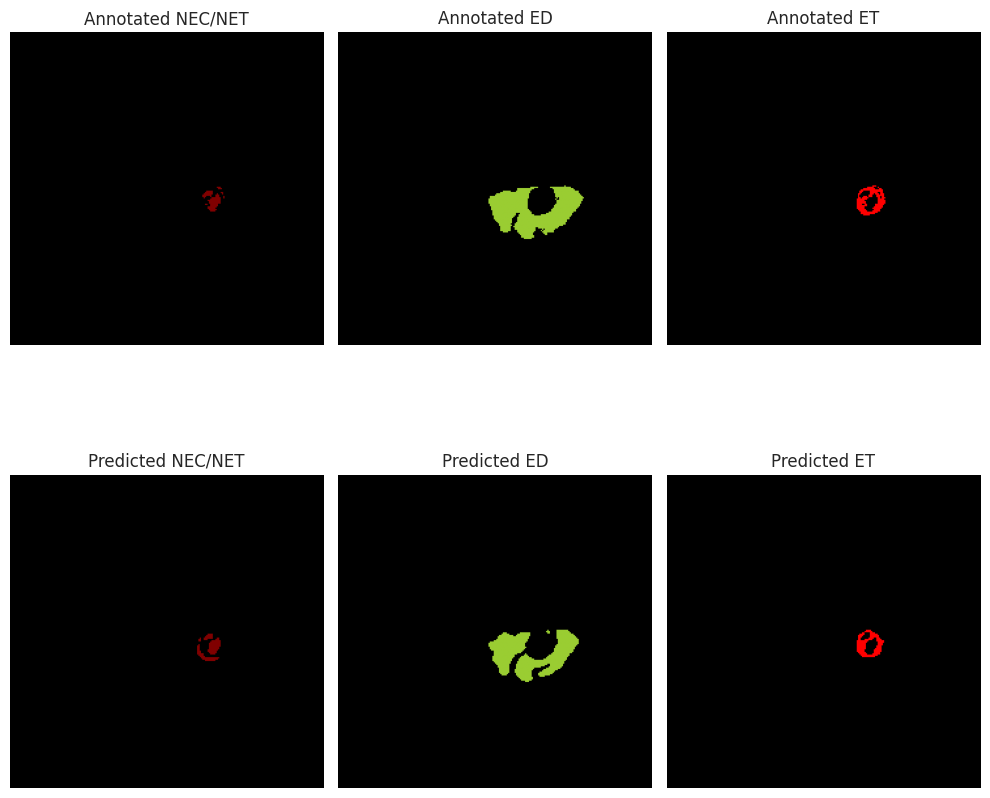

In [ ]:
# Select a specific validation slice
slice_index = 23

image, mask = val_dataset[slice_index]

# Add batch dimension (model expects B,C,H,W)
image = image.unsqueeze(0).to(device)
mask = mask.unsqueeze(0).to(device)

# Set model to eval mode
model.eval()

with torch.no_grad():
    output = model(image)
    probs = torch.sigmoid(output)
    pred = (probs > 0.5).float()

# Move everything to CPU for plotting
image = image.cpu()
mask = mask.cpu()
pred = pred.cpu()

# Remove batch dimension for plotting
image = image[0]
mask = mask[0]
pred = pred[0]

# Set up figure
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

# Iterable colors and plot titles
channel_colors = ['maroon', 'yellowgreen', 'red']
actual_titles = ['Annotated NEC/NET', 'Annotated ED', 'Annotated ET']
pred_titles = ['Predicted NEC/NET', 'Predicted ED', 'Predicted ET']

# Ground Truth
for c in range(3):
    annotated_cmap = ListedColormap(['black', channel_colors[c]])
    axes[0, c].imshow(mask[c], cmap=annotated_cmap, vmin=0, vmax=1)
    axes[0, c].set_title(actual_titles[c])
    axes[0, c].axis('off')

# Predictions
for c in range(3):
    pred_cmap = ListedColormap(['black', channel_colors[c]])
    axes[1, c].imshow(pred[c], cmap=pred_cmap, vmin=0, vmax=1)
    axes[1, c].set_title(pred_titles[c])
    axes[1, c].axis('off')

plt.tight_layout()
plt.show()

As seen from a slice example, the visual evaluation can be misleading as this particular slice shows strong predictions while the evaluation metrics are not up to par.